In [1]:
!hostname

77e21131c1f8


In [2]:
import pandas
import numpy
import pickle
import matplotlib.pyplot as plt
import time

https://docs.python.org/3.4/library/multiprocessing.html

The Process class sends each task to a different processor.<BR>
Process is most useful for a small number of processes where each process would take a longer time to execute.

The Pool class sends sets of tasks to different processors. <BR>
Pool is most useful for large amounts of processes where each process can execute quickly

source: https://medium.com/@urban_institute/using-multiprocessing-to-make-python-code-faster-23ea5ef996ba 


In [3]:
import multiprocessing
from multiprocessing import Process 
import os

https://stackoverflow.com/questions/47989418/multiprocessing-python-program-inside-docker

https://docs.docker.com/config/containers/resource_constraints/#configure-the-default-cfs-scheduler

In [4]:
def proc_info(title):
    print(title)
    print('\nmodule name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())

def myfunc(name):
    print('I am in myfunc')
    proc_info('function myfunc')
    print('end of myfunc', name)

In [5]:
if __name__ == '__main__':
    proc_info('main line') # display info about this process
    p = Process(target=myfunc, args=('bob',))
    p.start()
    p.join()

main line

module name: __main__
parent process: 7
process id: 5524
I am in myfunc
function myfunc

module name: __main__
parent process: 5524
process id: 5542
end of myfunc bob


https://docs.python.org/3.4/library/multiprocessing.html#using-a-pool-of-workers

In [6]:
from multiprocessing import Pool

In [7]:
def sq_fun(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(sq_fun, [1, 2, 3]))

[1, 4, 9]


To see what this might be useful for, let's first create random dataframe

https://stackoverflow.com/questions/32752292/how-to-create-a-data-frame-of-random-integers-with-pandas

In [8]:
df = pandas.DataFrame(
    numpy.random.randint(0,1000,size=(100000, 4)), 
    columns=list('ABCD')
    )
print(df.shape)
df.head()

(100000, 4)


,A,B,C,D
0,391,459,623,995
1,494,69,986,809
2,186,750,606,638
3,918,678,585,982
4,861,101,714,664


Task: Create a new column ('K') that is double the value of entries in column 'A'

First we'll implement the per-row operation:

In [9]:
def double_col_a(row):
    row_as_dict=dict(row)
    return row_as_dict['A']*2

In [10]:
start_time = time.time()
df['K']=df.apply(double_col_a,axis=1)
print(time.time() - start_time,'seconds')

13.976135969161987 seconds


Loop over increasing number of rows to inspect scaling

In [11]:
number_of_tests=10
# serial:          .2    2     15    165     340      1 hour
# concurrent:    
#list_of_row_size=[100, 1000, 10000]
list_of_row_size=[100, 1000, 10000, 100000, 100000]
#list_of_row_size=[100, 1000, 10000, 100000, 100000, 1000000, 10000000]#, 100000000, 1000000000]: # out of memory?

In [12]:
serial_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        df['K'] = df.apply(double_col_a,axis=1)
        test_reslts.append(time.time() - start_time)
    serial_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 0.19127106666564941 for 100
elapsed time: 1.5991878509521484 for 1000
elapsed time: 16.955924034118652 for 10000
elapsed time: 202.63489937782288 for 100000
elapsed time: 364.6791341304779 for 100000


Because the dataframe is large, it takes a while to perform the operations sequentially to each row

In [13]:
serial_reslts

{100: 0.018373274803161622,
 1000: 0.1399479866027832,
 10000: 1.534554696083069,
 100000: 16.199815654754637}

As expected, computation time scales linearly with number of rows

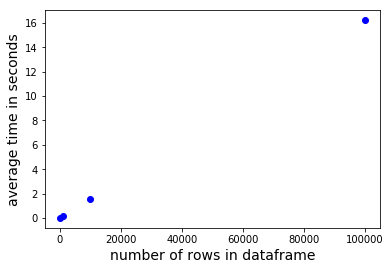

In [14]:
serial_x = list(serial_reslts.keys()) # list_of_row_size
serial_y = list(serial_reslts.values())
_=plt.scatter(serial_x,serial_y,color='blue')
#ax = plt.gca()
#ax.set_xscale('log')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)

With a linear fit:

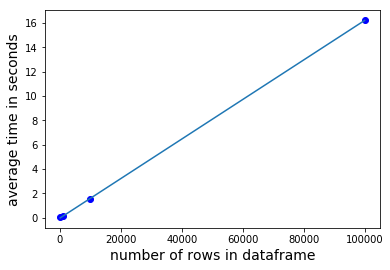

In [15]:
_=plt.scatter(serial_x,serial_y,color='blue')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x))) # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

Alternatively, we can spread the computation across the multiple cores

source: http://www.racketracer.com/2016/07/06/pandas-in-parallel/

In [16]:
num_cores = multiprocessing.cpu_count() #number of cores on your machine
print(num_cores)
num_partitions = num_cores #number of partitions to split dataframe

2


In [17]:
def multiply_columns(data):
    data['K']=data.apply(double_col_a,axis=1)
    return data

http://blog.adeel.io/2016/11/06/parallelize-pandas-map-or-apply/

In [18]:
def parallelize_dataframe(df, func,num_cores,num_partitions):
    df_split = numpy.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pandas.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [19]:
df.shape

(100000, 5)

In [20]:
start_time = time.time()
df = parallelize_dataframe(df, multiply_columns,num_cores,num_partitions)
print(time.time() - start_time,'seconds')

11.357390642166138 seconds


Let's compare scaling

In [21]:
pool_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        df = parallelize_dataframe(df, multiply_columns,num_cores,num_partitions)
        test_reslts.append(time.time() - start_time)
    pool_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 1.4227330684661865 for 100
elapsed time: 4.07961893081665 for 1000
elapsed time: 14.988365888595581 for 10000
elapsed time: 122.52316975593567 for 100000
elapsed time: 225.19704246520996 for 100000


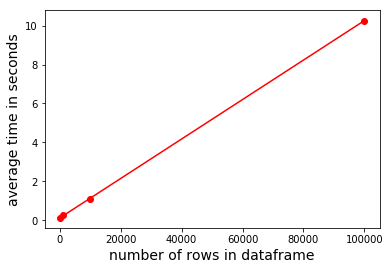

In [22]:
pool_x = list(pool_reslts.keys()) # list_of_row_size
pool_y = list(pool_reslts.values())
_=plt.scatter(pool_x,pool_y,color='red')
#ax = plt.gca()
#ax.set_xscale('log')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x)),color='red') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

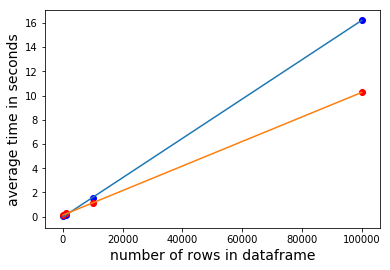

In [23]:
_=plt.scatter(serial_x,serial_y,color='blue')
_=plt.scatter(pool_x,pool_y,color='red')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x))) # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x))) # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

Looks like a win.

Let's zoom in on the initial (small) arrays:

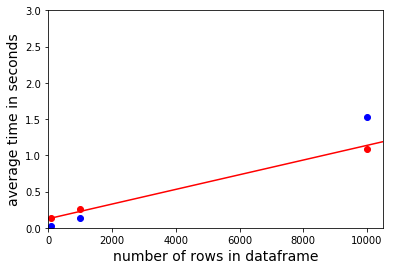

In [24]:
_=plt.scatter(serial_x,serial_y,color='blue')
_=plt.scatter(pool_x,pool_y,color='red')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.xlim(0,10500) 
_=plt.ylim(0,3)
#_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x))) # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x)),color='red') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

There an initialization cost (where serial is faster than concurrent), but with a sufficient number of rows the cost is amortized.

<BR>
<BR>


There are alternatives that avoid creating new processes.

We could use a lambda function 
https://www.w3schools.com/python/python_lambda.asp
to perform element-wise doubling much more efficiently.

"lambda" indicates an anonymous function -- a function without a name.<BR>
Normal functions are defined using the def keyword.
    
Usually I avoid lambda functions; here's reasoning: https://treyhunner.com/2018/09/stop-writing-lambda-expressions/

In [25]:
start_time = time.time()
df['K'] = df['A'].apply(lambda x: x*2)
print(time.time() - start_time)

0.10187172889709473


Which is much faster than the per-row approach:

In [26]:
start_time = time.time()
df['K']=df.apply(double_col_a,axis=1)
print(time.time() - start_time,'seconds')

18.429989337921143 seconds


In [27]:
lambda_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        df['K'] = df['A'].apply(lambda x: x*2)
        #df['K'] = df.apply(double_col_a,axis=1)
        test_reslts.append(time.time() - start_time)
    lambda_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 0.059058189392089844 for 100
elapsed time: 0.0913846492767334 for 1000
elapsed time: 0.1850292682647705 for 10000
elapsed time: 0.8981673717498779 for 100000
elapsed time: 1.594214677810669 for 100000


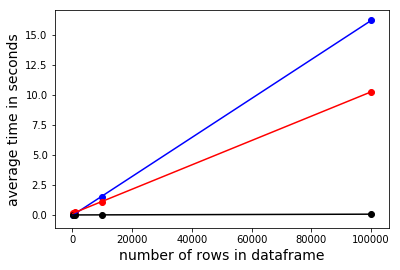

In [28]:
lambda_x = list(lambda_reslts.keys()) # list_of_row_size
lambda_y = list(lambda_reslts.values())

_=plt.scatter(serial_x,serial_y,color='blue')
_=plt.scatter(pool_x,pool_y,color='red')
_=plt.scatter(lambda_x,lambda_y,color='black')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x)),color='blue') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x)),color='red') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(lambda_x), numpy.poly1d(numpy.polyfit(lambda_x, lambda_y, 1))(numpy.unique(lambda_x)),color='black') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

Confusingly, doubling the compute power takes the same task twice as long. Not what I was expecting. Issue: Syncronization overhead. Data is copied to other processes on other cores. Multiplying numbers is faster than creating a new process.

- processes are spawned when needed. Before you perform performance timings, you should "warm up" the Pool with a line like <BR>
`pool.map(f, range(mul.cpu_count()))`
(starting a process is a slowish operation specially on Windows)
This reduces timings by a factor of two.

- the dispatch overhead of multiprocessing is certainly greater than a
single multiplication. multiprocessing is for CPU-bound functions!
And do not forget that you have *tree* processes here: two from the
Pool, and your main program.

Source: https://bugs.python.org/issue5000

In [29]:
# Saving the objects:
with open('multiprocessing_data.pkl', 'wb') as f:
    pickle.dump([serial_reslts, pool_reslts, lambda_reslts], f)

# Getting back the objects:
#with open('objs.pkl','rb') as f: 
#    obj0, obj1, obj2 = pickle.load(f)

In [30]:
!ls *.pkl

multiprocessing_data.pkl
